In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
# Depths will be limited to COW depths
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row


eddy = the_frontier_eddies[3] # Choose Eddy


sub_data = {}
for t in range(30):
    
    method = 'VG'
    sub_data['T'+str(t)] = {}
    
    df = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_df.loc[eddy]['T'+str(t)]]
    df = df.drop('TD', axis=1)
    
    # Interpolate to Density intervals
    rho = frontier_sample_data[eddy]['T'+str(t)]['rho']
    X, Y = np.meshgrid(frontier_sample_data[eddy]['T'+str(t)]['x'],
                       frontier_sample_data[eddy]['T'+str(t)]['y'])
    points = np.column_stack((X.ravel(), Y.ravel()))
    rhoc = []
    for k, (xc, yc) in enumerate(zip(df['x'], df['y'])):
        values = rho[:, :, k].ravel()
        target_point = np.array([[xc, yc]])
        rhoc.append(griddata(points, values, target_point, method='linear')[0])
    RHO_INT = 0.05
    new_rho = np.arange(np.floor(np.nanmin(rhoc) / RHO_INT) * RHO_INT,
                    np.ceil(np.nanmax(rhoc) / RHO_INT) * RHO_INT + RHO_INT,
                    RHO_INT)
    new_rho = [round(value, 2) for value in new_rho]
    rho_data = pd.DataFrame({
        'x': np.interp(new_rho, rhoc, df['x']),
        'y': np.interp(new_rho, rhoc, df['y']),
        'Depth': np.interp(new_rho, rhoc, df['Depth']),
        'rho': new_rho
    })
    x0 = rho_data.iloc[0]['x']
    y0 = rho_data.iloc[0]['y']
    rho_data['x'] = rho_data['x'] - x0
    rho_data['y'] = rho_data['y'] - y0
    rho_data['TD'] = np.hypot(rho_data['x'], rho_data['y'])
    
    # Interpolate to Depth intervals
    DEPTH_INT = 10
    new_depth = np.arange(0, -np.floor(df['Depth'].min()/DEPTH_INT) * DEPTH_INT + DEPTH_INT, DEPTH_INT)
    depth_data = pd.DataFrame({
        'x': np.interp(new_depth, -df['Depth'], df['x']),
        'y': np.interp(new_depth, -df['Depth'], df['y']),
        'Depth': -new_depth,
        'rho': np.interp(new_depth, -df['Depth'], rhoc),
    })
    x0 = depth_data.iloc[0]['x']
    y0 = depth_data.iloc[0]['y']
    depth_data['x'] = depth_data['x'] - x0
    depth_data['y'] = depth_data['y'] - y0
    depth_data['TD'] = np.hypot(depth_data['x'], depth_data['y'])

    sub_data['T'+str(t)]['rho_data'] = rho_data
    sub_data['T'+str(t)]['depth_data'] = depth_data
    print(t)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Depth

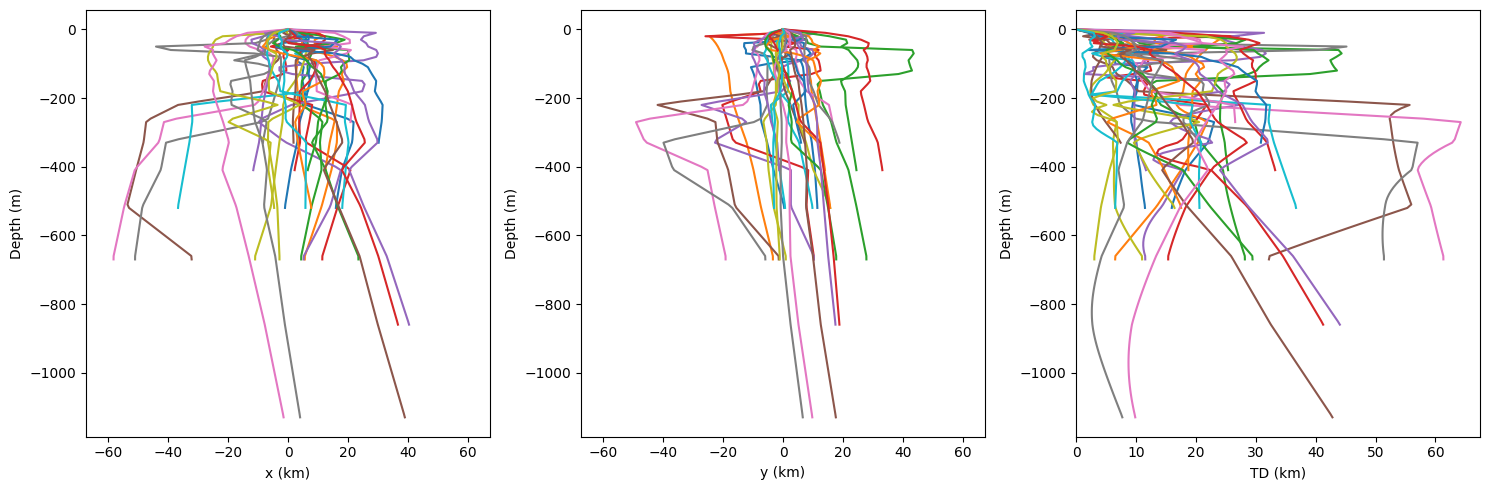

In [4]:
# PROCESS DATA INTO DATAFRAME

depth_dfs = []
for t in range(30):
    for col in ['x', 'y', 'TD']:
        depth_data = sub_data[f'T{t}']['depth_data'][['Depth', col]]
        depth_data.columns = ['Depth', f'{col}{t}']
        depth_dfs.append(depth_data.set_index('Depth'))

depth_df = pd.concat(depth_dfs, axis=1).sort_index(ascending=False)

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
for col in depth_df.columns:
    if 'x' in col:
        axs[0].plot(depth_df[col]/1000, depth_df.index)
        axs[0].set_xlabel('x (km)')
        axs[0].set_ylabel('Depth (m)')
    if 'y' in col:
        axs[1].plot(depth_df[col]/1000, depth_df.index)
        axs[1].set_xlabel('y (km)')
        axs[1].set_ylabel('Depth (m)')
    if 'TD' in col:
        axs[2].plot(depth_df[col]/1000, depth_df.index)
        axs[2].set_xlabel('TD (km)')
        axs[2].set_ylabel('Depth (m)')

xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)

axs[0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[2].set_xlim(0, max(abs(xmin),abs(xmax)))

plt.tight_layout()
plt.show()

In [5]:
depth_df

,x0,y0,TD0,x1,y1,TD1,x2,y2,TD2,x3,...,TD26,x27,y27,TD27,x28,y28,TD28,x29,y29,TD29
Depth,,,,,,,,,,,,,,,,,,,,,
-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-10.0,2223.837742,1686.255341,2790.862121,2165.357735,1559.262365,2668.346537,3692.571980,2120.423980,4258.084743,1397.429316,...,13696.684858,-6336.905666,752.634390,6381.444347,-4558.974358,-42.619297,4559.173565,-2902.623458,449.302948,2937.191870
-20.0,2743.754137,3034.786049,4091.223916,4067.040362,-24506.668562,24841.852212,5937.022964,4902.921685,7699.797577,8198.874314,...,17363.525047,-8081.916436,830.183068,8124.443194,-5950.680411,-207.270459,5954.289075,-3071.855420,-747.141090,3161.410370
-30.0,4086.207547,7760.628081,8770.657919,4775.260361,-23374.542749,23857.333469,5969.661941,7902.285676,9903.685304,-1980.155762,...,19517.662847,-9147.200354,853.629447,9186.944952,-6635.453103,-152.559068,6637.206652,-2183.057985,-967.241516,2387.739164
-40.0,5307.593639,-12934.087264,13980.742598,4689.618498,-22482.684495,22966.576231,6603.509457,8318.948202,10621.263406,-1923.749960,...,21191.620716,-9479.382579,739.142885,9508.155777,-6973.337391,-89.688702,6973.914140,-1994.026167,-1299.451133,2380.065882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9416.864296,3299.510209,6005.969942,6852.623042,NaN,NaN,NaN,NaN,NaN,NaN
-1100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9527.190678,3488.017244,6157.043371,7076.400735,NaN,NaN,NaN,NaN,NaN,NaN
-1110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9644.983190,3676.524279,6308.116800,7301.312782,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# COMPUTE RMSE FOR DIFFERENT SHIFTS

DEPTH_THRESH = 0

x0 = depth_df['x14'].loc[depth_df.index <= DEPTH_THRESH]/1000
y0 = depth_df['y14'].loc[depth_df.index <= DEPTH_THRESH]/1000
TD0 = depth_df['TD14'].loc[depth_df.index <= DEPTH_THRESH]/1000 # CHOOSE FROM SEPCIFIC DEPTH

x_shift_df = pd.DataFrame(columns=['Day', 'i', 'rmse'])
y_shift_df = pd.DataFrame(columns=['Day', 'i', 'rmse'])
TD_shift_df = pd.DataFrame(columns=['Day', 'i', 'rmse'])

tic = time.time()
for col in depth_df.columns:
    t = extract_number(col)

    for i_shift in range(-20, 20):

        if 'x' in col:
            x1 = depth_df[col].loc[depth_df.index <= DEPTH_THRESH]/1000 + i_shift
            rmse_x = np.sqrt(np.nanmean((x1 - x0) ** 2))

            x_shift_df.loc[len(x_shift_df)] = {
                'Day': t,
                'i': i_shift,
                'rmse': rmse_x,
            }
        elif 'y' in col:
            y1 = depth_df[col].loc[depth_df.index <= DEPTH_THRESH]/1000 + i_shift
            rmse_y = np.sqrt(np.nanmean((y1 - y0) ** 2))

            y_shift_df.loc[len(y_shift_df)] = {
                'Day': t,
                'i': i_shift,
                'rmse': rmse_y,
            }
        elif 'TD' in col:
            TD1 = depth_df[col].loc[depth_df.index <= DEPTH_THRESH]/1000 + i_shift
            rmse_TD = np.sqrt(np.nanmean((TD1 - TD0) ** 2))
            TD_shift_df.loc[len(TD_shift_df)] = {
                    'Day': t,
                    'i': i_shift,
                    'rmse': rmse_TD,
                }
                    
    if 'TD' in col:
        print(t)
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Elapsed time: 2.6549 seconds


In [7]:
# FIND OPTIMAL SHIFTS

x_best_shift_df = pd.DataFrame()
for t in x_shift_df['Day'].unique():
    day_df = x_shift_df.loc[x_shift_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        x_best_shift_df = pd.concat([x_best_shift_df, day_df_nonan.loc[[min_rmse_idx]]])
x_best_shift_df.set_index('Day', inplace=True)
x_best_shift_df.columns = ['ix', 'rmsex']

y_best_shift_df = pd.DataFrame()
for t in y_shift_df['Day'].unique():
    day_df = y_shift_df.loc[y_shift_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        y_best_shift_df = pd.concat([y_best_shift_df, day_df_nonan.loc[[min_rmse_idx]]])
y_best_shift_df.set_index('Day', inplace=True)
y_best_shift_df.columns = ['iy', 'rmsey']

TD_best_shift_df = pd.DataFrame()
for t in TD_shift_df['Day'].unique():
    day_df = TD_shift_df.loc[TD_shift_df['Day'] == t]
    day_df_nonan = day_df.dropna(subset=['rmse']) 
    if not day_df_nonan.empty:  
        min_rmse_idx = day_df_nonan['rmse'].idxmin()
        TD_best_shift_df = pd.concat([TD_best_shift_df, day_df_nonan.loc[[min_rmse_idx]]])
TD_best_shift_df.set_index('Day', inplace=True)
TD_best_shift_df.columns = ['iTD', 'rmseTD']

best_shift_df = pd.concat([x_best_shift_df, y_best_shift_df, TD_best_shift_df], axis=1)
best_shift_df

,ix,rmsex,iy,rmsey,iTD,rmseTD
Day,,,,,,
0,-20,9.199929,1,4.448088,-4,6.128679
1,-17,7.585664,10,3.208243,-9,2.824602
2,-16,4.736365,-20,14.619240,-12,10.709531
3,-12,8.887868,1,13.334652,-4,6.249652
4,-19,13.297785,1,12.882752,-9,7.509328
5,18,19.323065,9,13.999840,-20,23.418695
6,15,16.250716,17,18.129684,-20,23.483405
7,8,15.207816,10,16.134199,-13,20.809815
8,-9,3.057663,-1,3.789962,5,1.977646


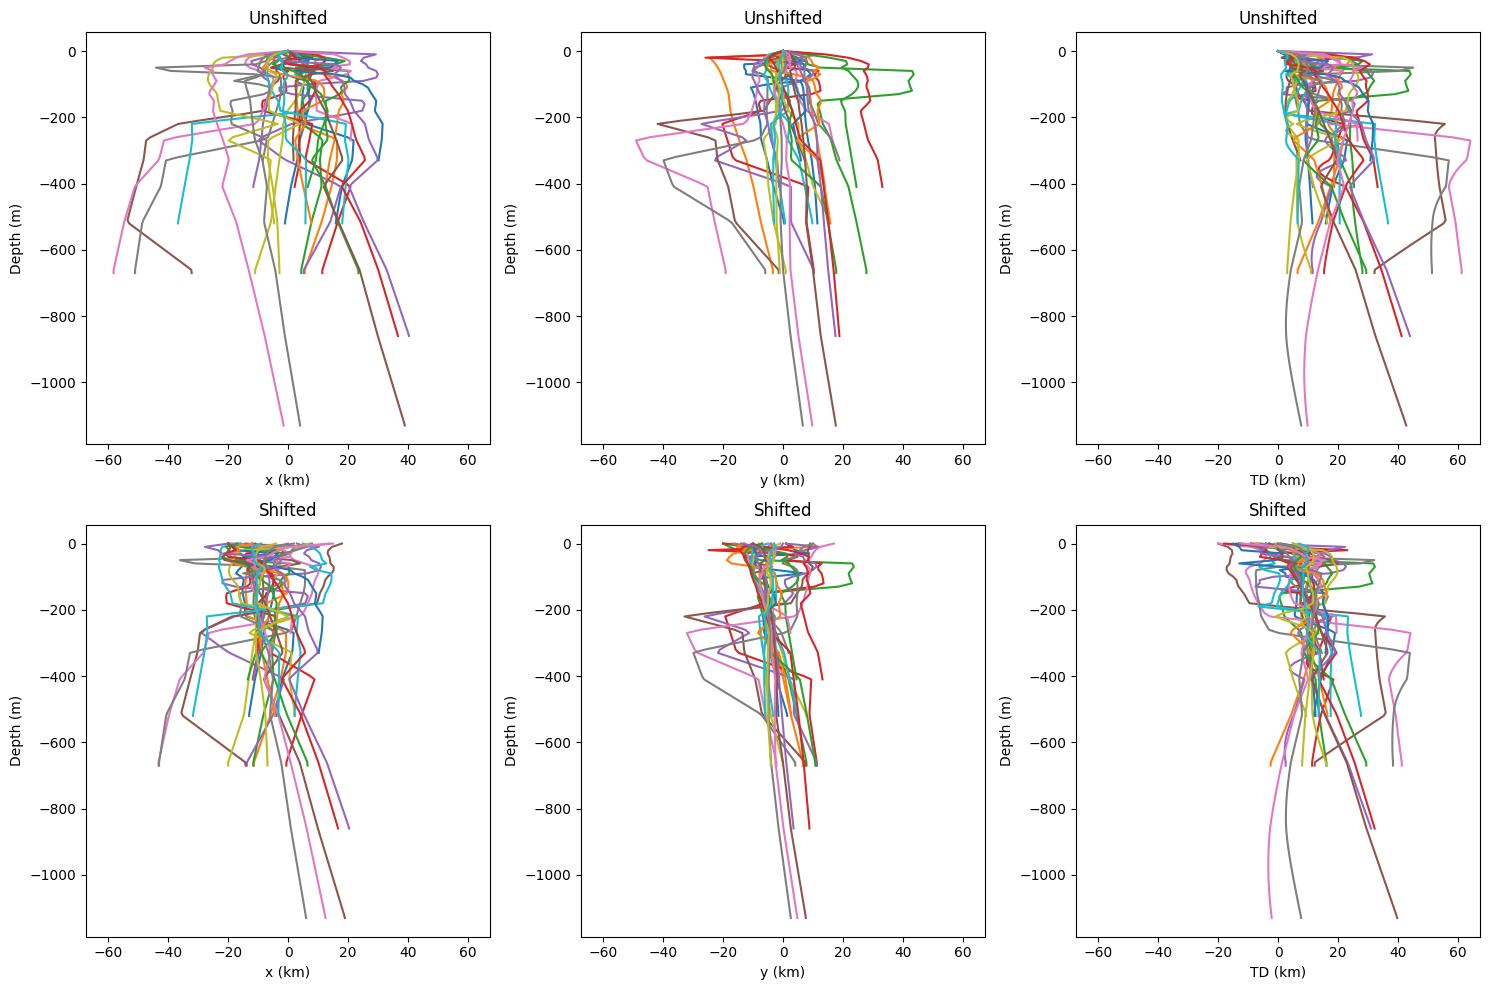

In [8]:
# SHFIT RESULTS

fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 
for col in depth_df.columns:
    t = extract_number(col)
    if 'x' in col:
        axs[0,0].plot(depth_df[col]/1000, depth_df.index)
        axs[0,0].set_xlabel('x (km)')
        axs[0,0].set_ylabel('Depth (m)')
        axs[0,0].set_title('Unshifted')
        ix = best_shift_df.loc[t]['ix']
        x = depth_df[col]/1000 + ix
        axs[1,0].plot(x, depth_df.index)
        axs[1,0].set_xlabel('x (km)')
        axs[1,0].set_ylabel('Depth (m)')
        axs[1,0].set_title('Shifted')
    if 'y' in col:
        axs[0,1].plot(depth_df[col]/1000, depth_df.index)
        axs[0,1].set_xlabel('y (km)')
        axs[0,1].set_ylabel('Depth (m)')
        axs[0,1].set_title('Unshifted')
        iy = best_shift_df.loc[t]['iy']
        y = depth_df[col]/1000 + iy
        axs[1,1].plot(y, depth_df.index)
        axs[1,1].set_xlabel('y (km)')
        axs[1,1].set_ylabel('Depth (m)')
        axs[1,1].set_title('Shifted')
    if 'TD' in col:
        axs[0,2].plot(depth_df[col]/1000, depth_df.index)
        axs[0,2].set_xlabel('TD (km)')
        axs[0,2].set_ylabel('Depth (m)')
        axs[0,2].set_title('Unshifted')
        iTD = best_shift_df.loc[t]['iTD']
        TD = depth_df[col]/1000 + iTD
        axs[1,2].plot(TD, depth_df.index)
        axs[1,2].set_xlabel('TD (km)')
        axs[1,2].set_ylabel('Depth (m)')
        axs[1,2].set_title('Shifted')

xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)

for ax in axs.flat:
    ax.set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))

plt.tight_layout()
plt.show()

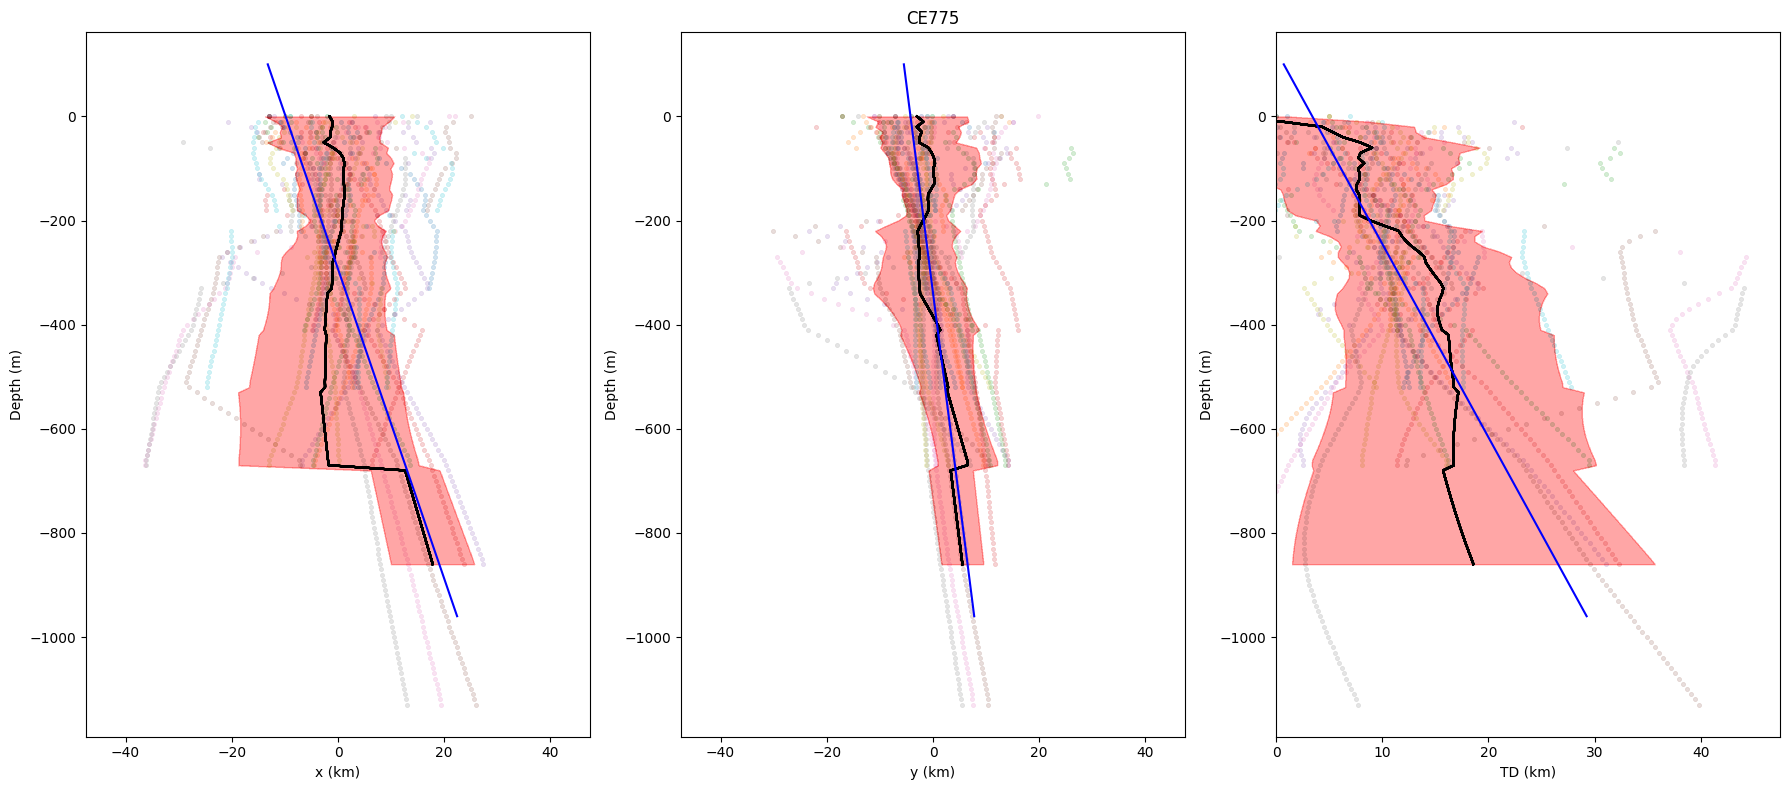

In [9]:
# LINEAR REGRESSION WITH SHIFT

shifted_depth_df = depth_df.copy()
for col in shifted_depth_df.columns:
    t = extract_number(col)
    if 'x' in col:
        ix = best_shift_df.loc[t]['ix']
        shifted_depth_df[col] = shifted_depth_df[col]/1000 + ix 
    if 'y' in col:
        iy = best_shift_df.loc[t]['iy']
        shifted_depth_df[col] = shifted_depth_df[col]/1000 + iy
    if 'TD' in col:
        iTD = best_shift_df.loc[t]['iTD']
        shifted_depth_df[col] = shifted_depth_df[col]/1000 + iTD

x_mean = shifted_depth_df.mean().filter(like='x').mean()
shifted_depth_df.loc[:, shifted_depth_df.columns.str.contains('x')] -= x_mean

y_mean = shifted_depth_df.mean().filter(like='y').mean()
shifted_depth_df.loc[:, shifted_depth_df.columns.str.contains('y')] -= y_mean

THRESHOLD = 5

x_df = shifted_depth_df.loc[:, shifted_depth_df.columns.str.contains('x')]
x_df = x_df[x_df.notna().sum(axis=1) >= THRESHOLD]
x_mean_d = x_df.mean(axis=1)
x_std_d = x_df.std(axis=1)

y_df = shifted_depth_df.loc[:, shifted_depth_df.columns.str.contains('y')]
y_df = y_df[y_df.notna().sum(axis=1) >= THRESHOLD]
y_mean_d = y_df.mean(axis=1)
y_std_d = y_df.std(axis=1)

TD_df = shifted_depth_df.loc[:, shifted_depth_df.columns.str.contains('TD')]
TD_df = TD_df[TD_df.notna().sum(axis=1) >= THRESHOLD]
TD_mean_d = TD_df.mean(axis=1)
TD_std_d = TD_df.std(axis=1)
# for col in shifted_depth_df.columns:
#     if 'TD' in col:
#         shifted_depth_df[col] -= TD_mean_d.iloc[0]
        
fig, axs = plt.subplots(1, 3, figsize=(18, 8)) 
for col in depth_df.columns:
    t = extract_number(col)
    if 'x' in col:
        x = shifted_depth_df[col]
        axs[0].scatter(x, depth_df.index, linewidth=.5, alpha=.2, zorder=-1, marker='.')
        axs[0].plot(x_mean_d, x_mean_d.index, color='k')
        axs[0].fill_betweenx(x_std_d.index, x_mean_d - x_std_d, x_mean_d + x_std_d, color='red', alpha=.01)
        axs[0].set_xlabel('x (km)')
        axs[0].set_ylabel('Depth (m)')

    if 'y' in col:
        y = shifted_depth_df[col]
        axs[1].scatter(y, depth_df.index, linewidth=.5, alpha=.2, zorder=-1, marker='.')
        axs[1].plot(y_mean_d, y_mean_d.index, color='k')
        axs[1].fill_betweenx(y_std_d.index, y_mean_d - y_std_d, y_mean_d + y_std_d, color='red', alpha=.01)
        axs[1].set_xlabel('y (km)')
        axs[1].set_ylabel('Depth (m)')
        axs[1].set_title('AE'+str(extract_number(eddy)) if eddies[eddy].iloc[0].Vort > 0 else 'CE'+str(extract_number(eddy)))

    if 'TD' in col:
        TD = shifted_depth_df[col]
        axs[2].scatter(TD, depth_df.index, linewidth=.5, alpha=.2, zorder=-1, marker='.')
        axs[2].plot(TD_mean_d, TD_mean_d.index, color='k')
        axs[2].fill_betweenx(TD_std_d.index, TD_mean_d - TD_std_d, TD_mean_d + TD_std_d, color='r', alpha=.01)
        axs[2].set_xlabel('TD (km)')
        axs[2].set_ylabel('Depth (m)')

# Linear Regression
means = [x_mean_d, y_mean_d, TD_mean_d]
stds = [x_std_d, y_std_d, TD_std_d]

for l, (mean, std) in enumerate(zip(means, stds)):

    x = mean
    z = mean.index
    w = 1 / std
    
    m, b = np.polyfit(x, z, 1, w=w)
    z_min, z_max = z.min() - 100, 100
    x_min = (z_min - b) / m
    x_max = (z_max - b) / m
    x_fit = np.array([x_min, x_max])
    z_fit = m * x_fit + b
    axs[l].plot(x_fit, z_fit, color='b')
    
xmax = 0
xmin = 0
for ax in axs.flat:
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)

axs[0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[2].set_xlim(0, max(abs(xmin),abs(xmax)))

plt.tight_layout()
plt.show()


## Optimal 3D Shift Computation

### Solve the Problem

$$
\huge x' = x\cos\theta - y\sin\theta + a
$$
$$
\huge y' = x\sin\theta + y\cos\theta + b
$$
\
$$
\begin{aligned}
\huge R(a, b, \theta) & \huge = \sum_i \left[x_i'(t_1) - x_i(t_2)\right]^2 + \left[y_i'(t_1) - y_i(t_2)\right]^2 \\
                      & \huge = \sum_i \left[x_i(t_1)\cos\theta - y_i(t_1)\sin\theta + a - x_i(t_2) \right]^2 + \left[x_i(t_1)\sin\theta + y_i(t_1)\cos\theta + b - y_i(t_2)\right]^2
\end{aligned}
$$

\
$$
\huge a = \overline{X}_2 - \overline{X}_1 \cos\theta + \overline{Y}_1 \sin\theta
$$

$$
\huge b = \overline{Y}_2 - \overline{Y}_1 \cos\theta - \overline{X}_1 \sin\theta
$$

$$
\huge \Longrightarrow \tan\theta = \frac{b\overline{X}_1-a\overline{Y}_1+A}{a\overline{X}_1+b\overline{Y}_1+B}
$$
$$
\huge  A = -\overline{X}_1\overline{Y}_2+\overline{Y}_1\overline{X}_2
$$
$$
\huge  B = -\overline{X}_1\overline{X}_2-\overline{Y}_1\overline{Y}_2
$$

\
$$
\huge \tan\theta = \frac{ b\overline{X}_1-a\overline{Y}_1+C }{ a\overline{X}_1+b\overline{Y}_1+D }
$$
$$
\huge C = \frac{Y_1\cdot X_2 - X_1\cdot Y_2}{N}
$$
$$
\huge D = \frac{-X_1\cdot X_2 - Y_1\cdot Y_2}{N}
$$

In [10]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

depth_df

,x0,y0,TD0,x1,y1,TD1,x2,y2,TD2,x3,...,TD26,x27,y27,TD27,x28,y28,TD28,x29,y29,TD29
Depth,,,,,,,,,,,,,,,,,,,,,
-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-10.0,2223.837742,1686.255341,2790.862121,2165.357735,1559.262365,2668.346537,3692.571980,2120.423980,4258.084743,1397.429316,...,13696.684858,-6336.905666,752.634390,6381.444347,-4558.974358,-42.619297,4559.173565,-2902.623458,449.302948,2937.191870
-20.0,2743.754137,3034.786049,4091.223916,4067.040362,-24506.668562,24841.852212,5937.022964,4902.921685,7699.797577,8198.874314,...,17363.525047,-8081.916436,830.183068,8124.443194,-5950.680411,-207.270459,5954.289075,-3071.855420,-747.141090,3161.410370
-30.0,4086.207547,7760.628081,8770.657919,4775.260361,-23374.542749,23857.333469,5969.661941,7902.285676,9903.685304,-1980.155762,...,19517.662847,-9147.200354,853.629447,9186.944952,-6635.453103,-152.559068,6637.206652,-2183.057985,-967.241516,2387.739164
-40.0,5307.593639,-12934.087264,13980.742598,4689.618498,-22482.684495,22966.576231,6603.509457,8318.948202,10621.263406,-1923.749960,...,21191.620716,-9479.382579,739.142885,9508.155777,-6973.337391,-89.688702,6973.914140,-1994.026167,-1299.451133,2380.065882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9416.864296,3299.510209,6005.969942,6852.623042,NaN,NaN,NaN,NaN,NaN,NaN
-1100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9527.190678,3488.017244,6157.043371,7076.400735,NaN,NaN,NaN,NaN,NaN,NaN
-1110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9644.983190,3676.524279,6308.116800,7301.312782,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from scipy.optimize import minimize

best_shift_3D_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'rmse'])
for t in range(30):
    # if t != 29:
        # Sample data 
        x_t1 = depth_df['x'+str(t)]/1000  # x-coordinates at t1
        y_t1 = depth_df['y'+str(t)]/1000   # y-coordinates at t1
        x_t2 = depth_df['x14']/1000  # x-coordinates at t2
        y_t2 = depth_df['y14']/1000   # y-coordinates at t2
    
        # Objective function
        def R(params):
            a, b, theta = params
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
            term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
            return np.sum(term1 + term2)
        
        # Initial guess for a, b, theta
        initial_guess = [0, 0, 0]
        
        # Optimize
        result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
        a_opt, b_opt, theta_opt = result.x
        rmse = R((a_opt, b_opt, theta_opt))
        theta_opt = np.rad2deg(theta_opt)
        
        # print(f"Optimal a: {a_opt}, b: {b_opt}, theta: {theta_opt}, rmse: {rmse}")
        best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'rmse': rmse}
    # else:
    #     best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'rmse': 0}
    
best_shift_3D_df.set_index('Day', inplace=True)
best_shift_3D_df

,theta,i,j,rmse
Day,,,,
0,109.271955,-10.471652,-17.551443,2564.984002
1,63.754203,-25.980674,-5.749488,2341.479130
2,174.602636,1.128624,14.131452,4846.593209
3,155.370532,-7.472196,-11.605592,6381.727739
4,0.000000,-18.595699,1.207385,14388.777351
5,0.000000,17.711759,9.055999,23910.186443
6,0.000000,14.842145,17.234504,24893.035761
7,0.000000,8.436420,10.031178,20638.741611
8,0.000000,-8.504985,-1.021558,985.639638


Optimal a: -13.393354885458736, b: -1.4679075795905243, theta: 5.680918700217887, rmse: 1268.93117726725


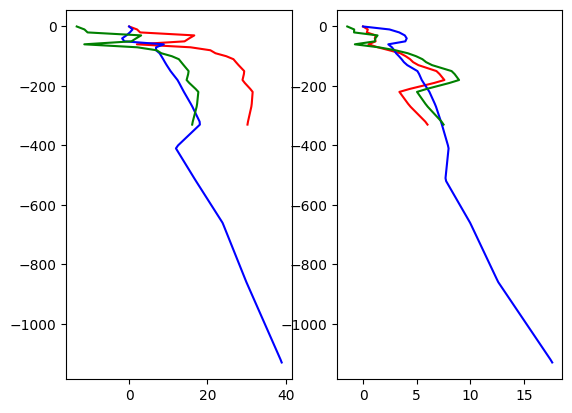

In [12]:
t = 20

x_t1 = depth_df['x'+str(t)]/1000  # x-coordinates at t1
y_t1 = depth_df['y'+str(t)]/1000   # y-coordinates at t1
x_t2 = depth_df['x'+str(t+5)]/1000  # x-coordinates at t2
y_t2 = depth_df['y'+str(t+5)]/1000   # y-coordinates at t2

# Objective function
def R(params):
    a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
    term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
    return np.sum(term1 + term2)

# Initial guess for a, b, theta
initial_guess = [0, 0, 0]

# Optimize
result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
a_opt, b_opt, theta_opt = result.x
rmse = R((a_opt, b_opt, theta_opt))
theta_opt = np.rad2deg(theta_opt)

print(f"Optimal a: {a_opt}, b: {b_opt}, theta: {theta_opt}, rmse: {rmse}")

fig, axs = plt.subplots(1, 2)

points_rotated = rotate_y_xy(np.column_stack((x_t1, y_t1)), theta_opt)
x_shifted = points_rotated[:, 0] + a_opt
y_shifted = points_rotated[:, 1] + b_opt


axs[0].plot(x_t1, x_t1.index, 'r')
axs[0].plot(x_t2, x_t2.index, 'b')

axs[0].plot(x_shifted, x_t1.index, 'g')

axs[1].plot(y_t1, y_t1.index, 'r')
axs[1].plot(y_t2, y_t2.index, 'b')

axs[1].plot(y_shifted, y_t1.index, 'g')

In [13]:
# cumsum_bottom_to_top = best_shift_3D_df.copy()

# cumsum_bottom_to_top = cumsum_bottom_to_top.iloc[::-1].cumsum().iloc[::-1]
# cumsum_bottom_to_top['theta'] = cumsum_bottom_to_top['theta'] % 360 
# cumsum_bottom_to_top

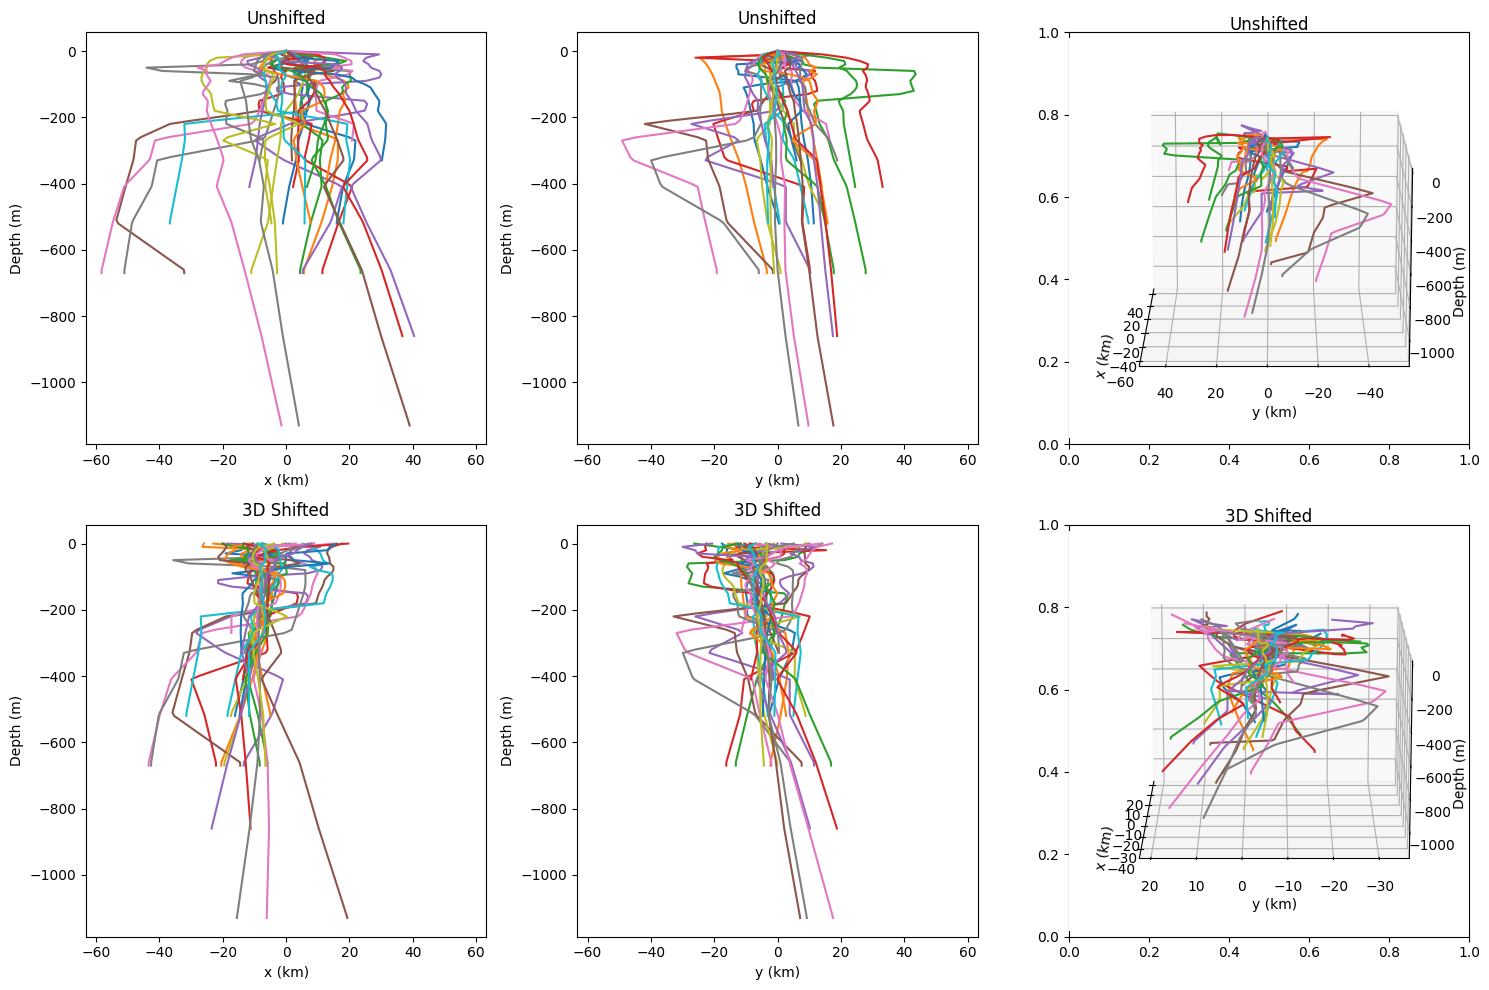

In [14]:
# SHFIT RESULTS
from mpl_toolkits.mplot3d import Axes3D
fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 

ax1 = axs[0,2].inset_axes([0, 0, 1, 1], projection='3d') 
ax2 = axs[1,2].inset_axes([0, 0, 1, 1], projection='3d')
for t in range(30):

    theta = best_shift_3D_df.loc[t]['theta']
    i = best_shift_3D_df.loc[t]['i']
    j = best_shift_3D_df.loc[t]['j']

    x = depth_df['x'+str(t)]/1000
    y = depth_df['y'+str(t)]/1000

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j
    
    axs[0,0].plot(x, depth_df.index)
    axs[0,0].set_xlabel('x (km)')
    axs[0,0].set_ylabel('Depth (m)')
    axs[0,0].set_title('Unshifted')

    axs[1,0].plot(x_shifted, depth_df.index)
    axs[1,0].set_xlabel('x (km)')
    axs[1,0].set_ylabel('Depth (m)')
    axs[1,0].set_title('3D Shifted')


    axs[0,1].plot(y, depth_df.index)
    axs[0,1].set_xlabel('y (km)')
    axs[0,1].set_ylabel('Depth (m)')
    axs[0,1].set_title('Unshifted')

    axs[1,1].plot(y_shifted, depth_df.index)
    axs[1,1].set_xlabel('y (km)')
    axs[1,1].set_ylabel('Depth (m)')
    axs[1,1].set_title('3D Shifted')

    # 3d plots
    ax1.plot(x, y, depth_df.index)
    ax1.set_xlabel('x (km)')
    ax1.set_ylabel('y (km)')
    ax1.set_zlabel('Depth (m)')
    ax1.set_title('Unshifted')

    ax2.plot(x_shifted, y_shifted, depth_df.index)
    ax2.set_xlabel('x (km)')
    ax2.set_ylabel('y (km)')
    ax2.set_zlabel('Depth (m)')
    ax2.set_title('3D Shifted')

xmax = 0
xmin = 0
for l, ax in enumerate(axs.flat):
    if l in [0, 1, 3, 4]:
        xmax = max(ax.get_xlim()[1], xmax)
        xmin = min(ax.get_xlim()[0], xmin)
  
axs[0,0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[0,1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1,0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1,1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))

ax1.view_init(15, 180)
ax2.view_init(15, 180)

plt.tight_layout()
plt.show()

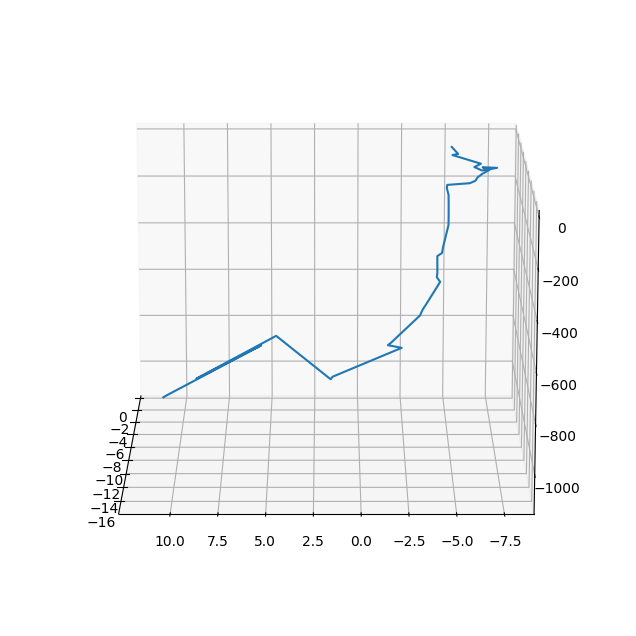

In [15]:
optimal_depth_df = depth_df.copy()
optimal_depth_df = optimal_depth_df.loc[:, ~optimal_depth_df.columns.str.contains('TD')]
for t in range(30):

    theta = best_shift_3D_df.loc[t]['theta']
    i = best_shift_3D_df.loc[t]['i']
    j = best_shift_3D_df.loc[t]['j']

    x = optimal_depth_df['x'+str(t)]/1000
    y = optimal_depth_df['y'+str(t)]/1000

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    optimal_depth_df['x'+str(t)] = x_shifted
    optimal_depth_df['y'+str(t)] = y_shifted

x_3D_mean = optimal_depth_df.filter(like='x').mean(axis=1)
x_3D_std = optimal_depth_df.filter(like='x').std(axis=1)
y_3D_mean = optimal_depth_df.filter(like='y').mean(axis=1)
y_3D_std = optimal_depth_df.filter(like='y').std(axis=1)

TD_3D_mean = np.hypot(x_3D_mean - x_3D_mean.iloc[0], y_3D_mean - y_3D_mean.iloc[0])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_3D_mean, y_3D_mean, x_3D_mean.index)
ax.view_init(15, 180)


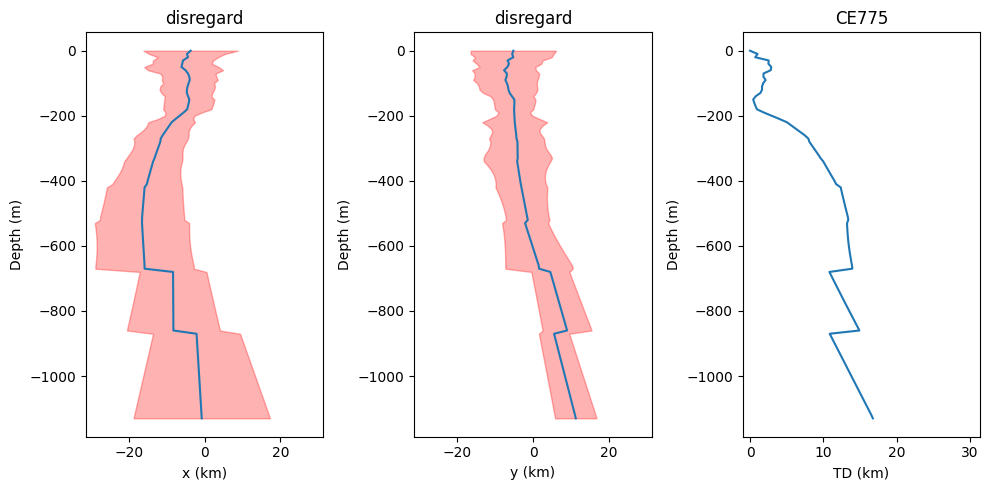

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5)) 

axs[0].plot(x_3D_mean, x_3D_mean.index)
axs[0].fill_betweenx(x_3D_std.index, x_3D_mean - x_3D_std, x_3D_mean + x_3D_std, color='r', alpha=.3)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('disregard')

axs[1].plot(y_3D_mean, y_3D_mean.index)
axs[1].fill_betweenx(y_3D_std.index, y_3D_mean - y_3D_std, y_3D_mean + y_3D_std, color='r', alpha=.3)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('disregard')

axs[2].plot(TD_3D_mean, TD_3D_mean.index)
axs[2].set_xlabel('TD (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title('AE'+str(extract_number(eddy)) if eddies[eddy].iloc[0].Vort > 0 else 'CE'+str(extract_number(eddy)))

xmax = 0
xmin = 0
for l, ax in enumerate(axs.flat):
    
    xmax = max(ax.get_xlim()[1], xmax)
    xmin = min(ax.get_xlim()[0], xmin)
  
axs[0].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[1].set_xlim(-max(abs(xmin),abs(xmax)), max(abs(xmin),abs(xmax)))
axs[2].set_xlim(-1, max(abs(xmin),abs(xmax)))

plt.tight_layout()